In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import pymysql.cursors
from timezonefinder import TimezoneFinder
import us
import json
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score

In [14]:
states = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
zones = ['HST','AKST', 'PST','MST', 'CST', 'EST']
# timezone to abbr map
abbr_map = {'America/Anchorage': 'AKST', 'America/Phoenix': 'MST', 'America/Denver': 'MST', 'Pacific/Honolulu': 'HST', 'America/New_York': 'EST', 'America/North_Dakota/Center': 'CST', 'America/Los_Angeles': 'PST', 'America/Chicago': 'CST', 'America/Indiana/Indianapolis': 'EST'}

# create mapping of state to timezone
timezone_map = dict()

# build timezone_map of state to timezone name
for state in states:
    s = us.states.lookup(state)
    timezone_map[state] = abbr_map[s.capital_tz]

print(timezone_map)
print(set(timezone_map.values()))


{'Alaska': 'AKST', 'Alabama': 'CST', 'Arkansas': 'CST', 'Arizona': 'MST', 'California': 'PST', 'Colorado': 'MST', 'Connecticut': 'EST', 'District of Columbia': 'EST', 'Delaware': 'EST', 'Florida': 'EST', 'Georgia': 'EST', 'Hawaii': 'HST', 'Iowa': 'CST', 'Idaho': 'MST', 'Illinois': 'CST', 'Indiana': 'EST', 'Kansas': 'CST', 'Kentucky': 'EST', 'Louisiana': 'CST', 'Massachusetts': 'EST', 'Maryland': 'EST', 'Maine': 'EST', 'Michigan': 'EST', 'Minnesota': 'CST', 'Missouri': 'CST', 'Mississippi': 'CST', 'Montana': 'MST', 'North Carolina': 'EST', 'North Dakota': 'CST', 'Nebraska': 'CST', 'New Hampshire': 'EST', 'New Jersey': 'EST', 'New Mexico': 'MST', 'Nevada': 'PST', 'New York': 'EST', 'Ohio': 'EST', 'Oklahoma': 'CST', 'Oregon': 'PST', 'Pennsylvania': 'EST', 'Rhode Island': 'EST', 'South Carolina': 'EST', 'South Dakota': 'CST', 'Tennessee': 'CST', 'Texas': 'CST', 'Utah': 'MST', 'Virginia': 'EST', 'Vermont': 'EST', 'Washington': 'PST', 'Wisconsin': 'CST', 'West Virginia': 'EST', 'Wyoming': 'M

In [9]:
# load dataset from mysql
# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='Qawsedrftg9!',
                             db='reddit_data',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)


# load users and cleaned tables
with connection.cursor() as cursor:
    sql = "SELECT * FROM `users`"
    cursor.execute(sql)
    users_rows = cursor.fetchall()
    sql = "SELECT username, timestamp_arr FROM `cleaned`"
    cursor.execute(sql)
    cleaned_rows = cursor.fetchall()

In [10]:
# create mapping of username -> state

In [11]:
# create mapping of username -> state
loc_table = dict()
for row in users_rows:
    loc = row['location']
    
    if loc not in states:
        # discard
        continue
    else:
        loc_table[row['username']] = loc

print("Created mapping of %d users to %d states" % (len(loc_table), len(set(loc_table.values()))))

Created mapping of 69247 users to 51 states


In [28]:
# create dataset
X = []
y = []

# extract data from rows
for i in range(len(cleaned_rows)):
    row = cleaned_rows[i]
    
    # convert to int list
    times = json.loads(row['timestamp_arr'].replace("\'", "\""))
    times = np.array(times).astype(np.float)
    
    # discard non-US entries
    username = row['username']
    if(username == '[deleted]') or username not in loc_table:
        continue
        
    zone = timezone_map[loc_table[username]]
    # normalize time vector
    times = times / np.linalg.norm(times)

    X.append(times)
    y.append(zone)
    
    if(i%10000 == 0):
        print("Processed %d entries" % i)

Processed 0 entries
Processed 10000 entries
Processed 20000 entries
Processed 30000 entries
Processed 50000 entries
Processed 60000 entries
Processed 70000 entries


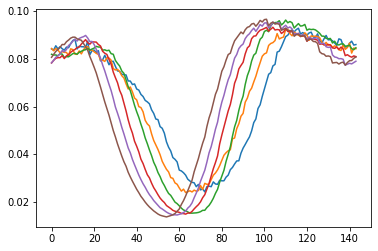

In [34]:
# for each timezone, sum up vector and graph
sum_table = dict()
count_table = dict()
for zone in zones:
    sum_table[zone] = np.zeros(144)
    count_table[zone] = 0

for (i, x) in enumerate(X):
    sum_table[y[i]] += x
    count_table[y[i]] += 1
    
for zone in zones:
    # average each timezone's sum by number of occurrences
    sum_table[zone] /= count_table[zone]
    plt.plot(range(144), sum_table[zone])

In [35]:
# split data into training and test
assert(len(X) == len(y))
l = 3 * len(y) // 4
X_train, X_test = X[0:l], X[l:]
y_train, y_test = y[0:l], y[l:]

print("Using %d entries for training, %d for test" % (len(X_train), len(X_test)))

Using 51934 entries for training, 17312 for test


In [42]:
# run logistical regression
log_reg = LogisticRegression(max_iter=10000000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=10000000)

In [50]:
score = log_reg.score(X_test, y_test)

print(log_reg.predict(X_test[1].reshape(1,-1)))
print(score)

['EST']
0.48151571164510165


In [39]:
C = 10
kernel = 1.0 * RBF(1.0)  # for GPC

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=C, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                      max_iter=10000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Linear SVC': SVC(kernel='linear', C=C, probability=True,
                      random_state=0, gamma='auto'),
    'GPC': GaussianProcessClassifier(kernel)
}

print("Hi")
GaussianProcessClassifier(verbose=True).fit(X_train, y_train)
print("Done training")
y_pred = classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

Hi


TypeError: __init__() got an unexpected keyword argument 'verbose'